# hw 5: kernel density estimation (KDE)

In [1]:
using CSV
using DataFrames
using PyPlot
using Statistics
using Random
using LaTeXStrings # for L"$x$" to work instead of needing to do "\$x\$"
using Printf

# (optional)change settings for all plots at once, e.g. font size
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16

# use PyCall to call in Seaborn
using PyCall
seaborn = pyimport("seaborn")

# note: some have done the following to bring `kdeplot` and `rugplot` into the namespace
#  but I recommend the above. you need to install Seaborn, the Python package.
# using Seaborn

PyObject <module 'seaborn' from 'C:\\Users\\OjBoba\\.julia\\conda\\3\\lib\\site-packages\\seaborn\\__init__.py'>

## data on forest fires in the northeast region of Portugal

(1) read in `forestfires.csv` as a `DataFrame`. [source](https://archive.ics.uci.edu/ml/datasets/Forest+Fires)

* each row corresponds to the occurance of a forest fire. 
* the `:temp` attribute is the temperature in Celsius degrees when the forest fire occurred
* the `:RH` attribute is the relative humidity in % when the forest fire occurred

In [2]:
df = CSV.read("forestfires.csv")
first(df,5)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH
,Int64,Int64,String,String,Float64,Float64,Float64,Float64,Float64,Int64
1,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51
2,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33
3,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33
4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97
5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99


## using Seaborn to do KDE

(2) use Seaborn's [kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) function and [rugplot](https://seaborn.pydata.org/generated/seaborn.rugplot.html) function to, on the same plot, draw a rugplot and 1D KDE of the temperature during forest fires in Portugal.

* shade in the area under the curve (see `shade` in the documentation)
* use the cosine kernel, denoted as `"cos"` in Seaborn (see `kernel` in the documentation) the cosine kernel has finite, compact support, unlike the Gaussian kernel
* label the x, y-axes with appropriate units (note: both have units!)

note regarding translation of Seaborn (Python) documentation to Julia: keep in mind that we need to pass strings `kernel="gau"` in Julia as opposed to `kernel='gau'` which works in Python.

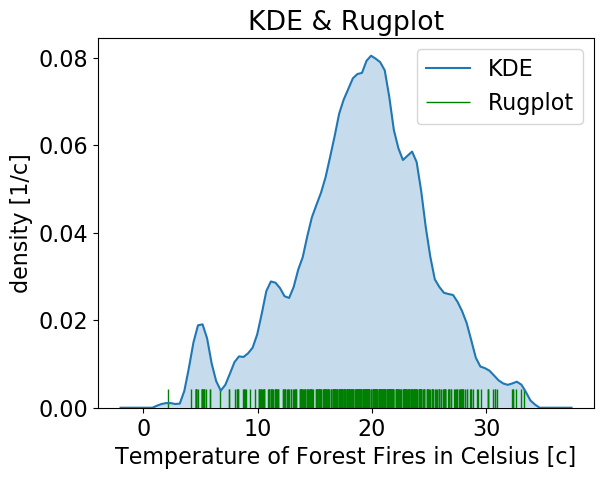

PyObject <matplotlib.legend.Legend object at 0x000000003DB19C88>

In [3]:
# https://seaborn.pydata.org/generated/seaborn.kdeplot.html
# seaborn.kdeplot(data, data2=None, shade=False, vertical=False, kernel='gau', bw='scott', gridsize=100, 
#     cut=3, clip=None, legend=True, cumulative=False, shade_lowest=True, cbar=False, 
#     cbar_ax=None, cbar_kws=None, ax=None, **kwargs)
seaborn.kdeplot(df[:, :temp], kernel="cos", bw = "silverman", shade = true, label = "KDE")  # kernal density estimation

# https://seaborn.pydata.org/generated/seaborn.rugplot.html
# seaborn.rugplot(a, height=0.05, axis='x', ax=None, **kwargs)
seaborn.rugplot(df[:, :temp], height = 0.05, color = "green", label = "Rugplot")  # Plot datapoints in an array as sticks on an axis


xlabel("Temperature of Forest Fires in Celsius [c]")
ylabel("density [1/c]")
title("KDE & Rugplot")
legend()

(3) draw a scatter plot to visualize the relationship, during forest fires, between:
* x-axis: temperature
* y-axis: relative humidity

label the x- and y-axes along with units.

use green "+" markers.

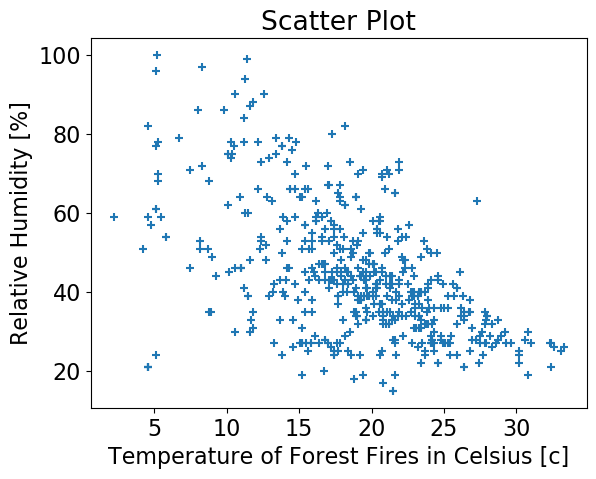

PyObject Text(0.5, 1, 'Scatter Plot')

In [4]:
scatter(df[:, :temp], df[:, :RH], marker="+")
xlabel("Temperature of Forest Fires in Celsius [c]")
ylabel("Relative Humidity [%]")
title("Scatter Plot")

(4) now draw a bivariate KDE using Seaborn's [kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) function that corresponds to your scatter plot in (3).
* devote the x-axis to temperature
* devote the y-axis to relative humidity
* label the x, y- axes with units
* pass `shade=true` to shade between the contours
* pass `shade_lowest=false` to avoid shading regions of temperature-relative humidity space where forest fires were very unlikely to occur.
* pass `cmap="Greens"` to change the colormap to use green colors for the shading.

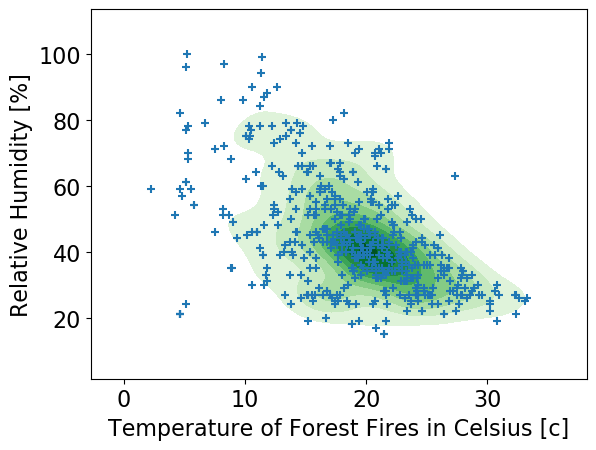

PyObject Text(33.000000000000014, 0.5, 'Relative Humidity [%]')

In [5]:
# https://seaborn.pydata.org/generated/seaborn.kdeplot.html
# seaborn.kdeplot(data, data2=None, shade=False, vertical=False, kernel='gau', bw='scott', gridsize=100, 
#     cut=3, clip=None, legend=True, cumulative=False, shade_lowest=True, cbar=False, 
#     cbar_ax=None, cbar_kws=None, ax=None, **kwargs)

seaborn.kdeplot(df[:,:temp],df[:,:RH], shade=true,shade_lowest=false,cmap="Greens")
scatter(df[:, :temp], df[:, :RH], marker="+")
xlabel("Temperature of Forest Fires in Celsius [c]")
ylabel("Relative Humidity [%]")

## coding up your own 1D top hat KDE
To intimately understand KDE, let's code up own own KDE with a new kernel we haven't seen before, the top hat function, which looks like a top hat. See what the top hat kernel looks like [here](https://scikit-learn.org/stable/_images/sphx_glr_plot_kde_1d_002.png). The top hat function has finite and compact [support](https://en.wikipedia.org/wiki/Support_(mathematics)) and is (piecewise) flat. The top hat kernel is implemented in scikitlearn's kernel density estimate module if you are interesting in checking your code. let $X$ denote the random variable whose density we seek to estimate (via top hat kernel density estimation).

(5) write a function `K_top_hat(x::Float64, x_i::Float64, λ::Float64)` the returns the value of the top hat kernel density at `x` conributed by data point `x_i`. `λ` is the bandwidth of the top hat kernel, which is half of its width. think carefully about what the height should be...

In [6]:
# the height of the tophat is H, the width is 2λ
# thus A = H * 2λ = 1 
# H = 1/(2λ)  

function K_top_hat(x::Float64, x_i::Float64, λ::Float64)
#     u = ((x-x_i)/λ)^2
#     u = (x-x_i)/λ 
    u = x-x_i
    if -λ < u < λ 
        return 1/(2*λ)
    else
        return 0.0
    end
end

K_top_hat (generic function with 1 method)

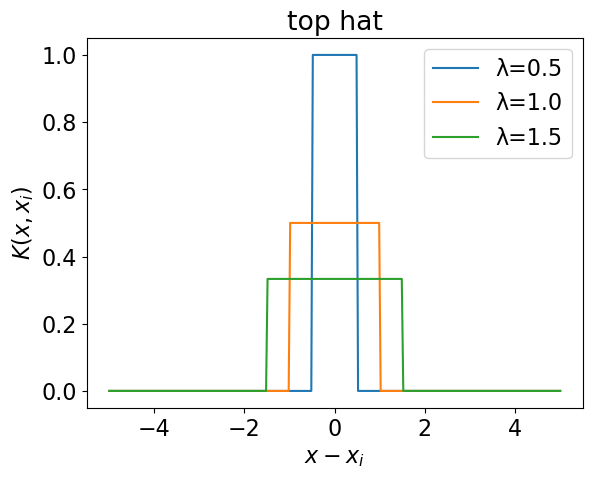

PyObject <matplotlib.legend.Legend object at 0x0000000040755FD0>

In [7]:
# Testing to see if the graph looks/resemble a top hat kernel 

x = 0.0
x_is = range(-5.0, stop=5.0, length=300)
λs = [0.5, 1.0, 1.5]

for λ in λs
    k = [K_top_hat(x, x_i, λ) for x_i in x_is]
    plot(x_is, k, label="λ=$λ")
    title("top hat")
    ylabel(L"$K(x, x_i)$")
end
xlabel(L"$x-x_i$")
legend()

(6) write a function `top_hat_kde(x::Float64, x_sample::Array{Float64}, λ::Float64)` that takes in the point `x` at which we seek to estimate the density, the array of samples of $x$ (the data and the `x_i`'s for `K_top_hat`) `x_sample`, and the bandwidth `λ` of the top hat kernel used to make the density estimate, then returns the top hat kernel density estimate at `x`.

In [8]:
# rule of thumb to pick bandwidth 
λ_silverman = (4 * std(df[:, :temp]) ^ 5 / (3 * nrow(df))) ^ (1 / 5)

1.7628422246352347

In [9]:
# This will return the kernel density at your chosen integer/float of x given your data array of x_sample 

function top_hat_kde(x::Float64, x_sample::Array{Float64}, λ::Float64)
    density_estimate = 0.0
    for i = 1:length(x_sample)
        density_estimate += K_top_hat(x, x_sample[i], λ)
    end
    return density_estimate / length(x_sample)
end

top_hat_kde (generic function with 1 method)

In [10]:
# Testing top_hat_kde function given x 

x = 20.0 # make sure to have a decimal to be a float 
λ = λ_silverman 
top_hat_kde(x, df[:,:temp], λ)

0.07735441916354865

(7) finally, use your function `top_hat_kde` to estimate the density of temperatures during forest fires in Portugal at a dense span of temperatures ranging from 0 to 50.0. Use a bandwidth of 1.5. plot the density as in question (2) and compare. What strikes you as a qualitative difference between the KDE using top hat vs. cosine kernel in (2)?

note: in comparing the scale on the y-axis here and in your plot from question (2) generated with Seaborn, you should get a hint of whether or not you chose the height of the top hat kernel correctly. Remember that the total kernel density should integrate to 1.0.

**The differences that can be seen are that the top hat estimation curve is not as smooth and it seems to miss or be short of some density peaks around certain temperatures ~(5, 11, and 23). Overall they do look very similiar with the shape and its highest peak at around 20.**  


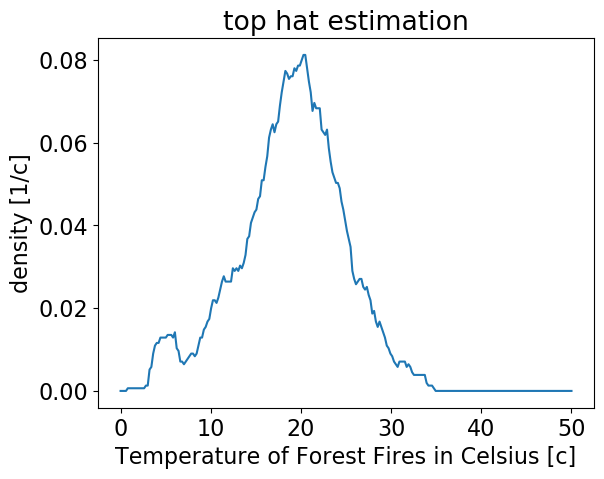

PyObject Text(0.5, 32.99999999999999, 'Temperature of Forest Fires in Celsius [c]')

In [11]:
temperatures = range(0.0, stop=50.0, length=250) # ask for a range from 0 to 50 
λ = 1.5 # using 1.5 bandwidth as mentioned 
ρ = [top_hat_kde(temp, df[:, :temp], λ) for temp in temperatures]
plot(temperatures, ρ)
title("top hat estimation")
ylabel("density [1/c]")
xlabel("Temperature of Forest Fires in Celsius [c]")

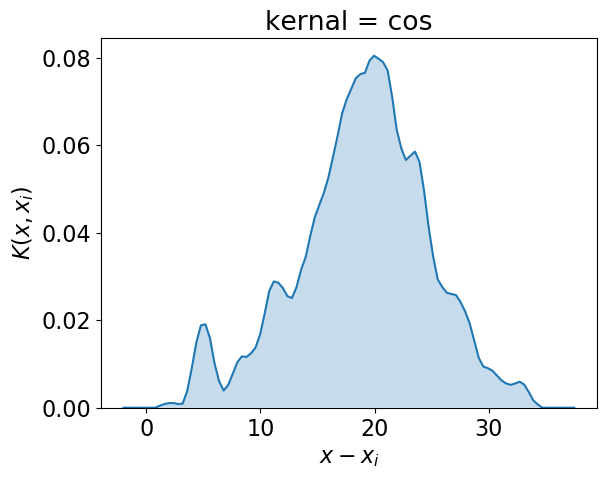

PyObject Text(0.5, 32.99999999999999, '$x-x_i$')

In [12]:
seaborn.kdeplot(df[:, :temp], kernel="cos", bw = "silverman", shade = true)  # kernal density estimation
title("kernal = cos")
ylabel(L"$K(x, x_i)$")
xlabel(L"$x-x_i$")

In [13]:
# Answer for question is mentioned above in bold 